## Chapter 5: Cross-Validation and Bootstrap ##

In [21]:
from __future__ import division
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import KFold
from scikits.bootstrap import bootstrap
#from sklearn.cross_validation import Bootstrap
from sklearn.metrics import mean_squared_error
%matplotlib inline

In [12]:
auto_df = pd.read_csv("../data/Auto.csv", na_values="?")
auto_df.dropna(inplace=True)
auto_df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8,307.0,130.0,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449,10.5,70,1,ford torino


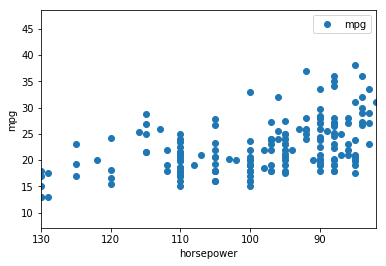

In [13]:
ax = auto_df.plot(x="horsepower", y="mpg", style="o")
ax.set_ylabel("mpg")

### Leave One Out Cross Validation (LOOCV) ###

Instead of R's glm, we use Scikit-Learn's LinearRegression to arrive at very similar results.

In [14]:
clf = LinearRegression()
loo = LeaveOneOut()
X = auto_df[["horsepower"]].values
y = auto_df["mpg"].values
n = np.shape(X)[0]
mses = []
for train, test in loo.split(X):
    Xtrain, ytrain, Xtest, ytest = X[train], y[train], X[test], y[test]
    clf.fit(Xtrain, ytrain)
    ypred = clf.predict(Xtest)
    mses.append(mean_squared_error(ytest, ypred))
np.mean(mses)

24.231513517929226

In [15]:
def loo_shortcut(X, y):
    """ implement one-pass LOOCV calculation for linear models from ISLR Page 180 (Eqn 5.2) """
    clf = LinearRegression()
    clf.fit(X, y)
    ypred = clf.predict(X)
    xbar = np.mean(X, axis=0)
    xsum = np.sum(np.power(X - xbar, 2))
    nrows = np.shape(X)[0]
    mses = []
    for row in range(0, nrows):
        hi = (1 / nrows) + (np.sum(X[row] - xbar) ** 2 / xsum)
        mse = (y[row] - ypred[row]) ** 2 / (1 - hi)
        mses.append(mse)
    return np.mean(mses)

loo_shortcut(auto_df[["horsepower"]].values, auto_df["mpg"].values)

24.086699242104977

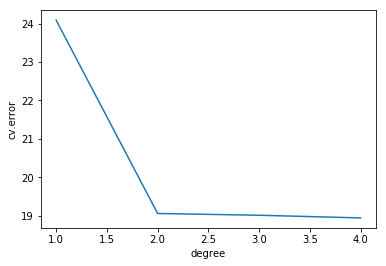

In [16]:
# LOOCV against models of different degrees
auto_df["horsepower^2"] = auto_df["horsepower"] * auto_df["horsepower"]
auto_df["horsepower^3"] = auto_df["horsepower^2"] * auto_df["horsepower"]
auto_df["horsepower^4"] = auto_df["horsepower^3"] * auto_df["horsepower"]
auto_df["horsepower^5"] = auto_df["horsepower^4"] * auto_df["horsepower"]
auto_df["unit"] = 1
colnames = ["unit", "horsepower", "horsepower^2", "horsepower^3", "horsepower^4", "horsepower^5"]
cv_errors = []
for ncols in range(2, 6):
    X = auto_df[colnames[0:ncols]]
    y = auto_df["mpg"]
    clf = LinearRegression()
    clf.fit(X, y)
    cv_errors.append(loo_shortcut(X.values, y.values))
plt.plot(range(1,5), cv_errors)
plt.xlabel("degree")
plt.ylabel("cv.error")

### K-Fold Cross Validation ###

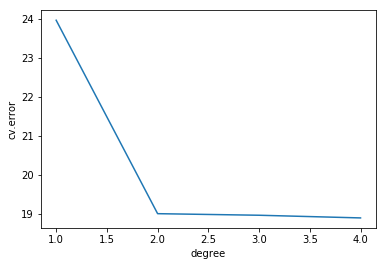

In [18]:
cv_errors = []
for ncols in range(2, 6):
    # each ncol corresponds to a polynomial model
    X = auto_df[colnames[0:ncols]].values
    y = auto_df["mpg"].values
    kfold = KFold(n_splits=10)
    mses = []
    for train, test in kfold.split(X):
        # each model is cross validated 10 times
        Xtrain, ytrain, Xtest, ytest = X[train], y[train], X[test], y[test]   
        clf = LinearRegression()
        clf.fit(X, y)
        ypred = clf.predict(Xtest)
        mses.append(mean_squared_error(ypred, ytest))
    cv_errors.append(np.mean(mses))
plt.plot(range(1,5), cv_errors)
plt.xlabel("degree")
plt.ylabel("cv.error")

### Bootstrap ###

In [23]:
cv_errors = []
for ncols in range(2, 6):
    # each ncol corresponds to a polynomial model
    X = auto_df[colnames[0:ncols]].values
    y = auto_df["mpg"].values
    n = len(auto_df)
    bs = Bootstrap(n, train_size=int(0.9*n), test_size=int(0.1*n), n_iter=10, random_state=0)
    mses = []
    for train, test in bs:
        # each model is resampled 10 times
        Xtrain, ytrain, Xtest, ytest = X[train], y[train], X[test], y[test]   
        clf = LinearRegression()
        clf.fit(X, y)
        ypred = clf.predict(Xtest)
        mses.append(mean_squared_error(ypred, ytest))
    cv_errors.append(np.mean(mses))
plt.plot(range(1,5), cv_errors)
plt.xlabel("degree")
plt.ylabel("cv.error")

TypeError: 'module' object is not callable

In [ ]:
def alpha(x, y):
    """ allocate alpha of your assets to x and (1-alpha) to y for optimum """
    vx = np.var(x)
    vy = np.var(y)
    cxy = np.cov(x, y)
    return ((vy - cxy) / (vx + vy - 2 * cxy))[0, 1]

# From ISLR package, retrieved with write.csv(Portfolio, "portfolio.csv", row.names=FALSE)
portfolio_df = pd.read_csv("../data/Portfolio.csv")
portfolio_df.head()

In [ ]:
alpha(portfolio_df["X"].values, portfolio_df["Y"].values)

In [ ]:
# Find the variance of alpha - shows that bootstrapping results in a near-normal distribution
X = portfolio_df["X"].values
Y = portfolio_df["Y"].values
bs = Bootstrap(len(portfolio_df), n_iter=1000, train_size=99, random_state=0)
alphas = []
for train, test in bs:
    xtrain, ytrain = X[train], Y[train]
    alphas.append(alpha(xtrain, ytrain))
plt.hist(alphas)